# Relax, Inc. Data Science Challenge
### Table 1: takehome_users
A user table with data on 12,000 users who signed up for the product in the last two years. This table includes:
* `name`: the user's name
* `object_id`: the user's id
* `email`: email address
* `creation_source`: how their account was created. This takes on one of 5 values:
    * *PERSONAL_PROJECTS*: invited to join another user's personal workspace
    * *GUEST_INVITE*: invited to an organization as a guest (limited permissions)
    * *ORG_INVITE*: invited to an organization (as a full member)
    * *SIGNUP*: signed up via the website
    * *SIGNUP_GOOGLE_AUTH*: signed up using Google Authentication (using a Google email account for their login
id)
* `creation_time`: when they created their account
* `last_session_creation_time`: unix timestamp of last login
* `opted_in_to_mailing_list`: whether they have opted into receiving marketing emails
* `enabled_for_marketing_drip`: whether they are on the regular marketing email drip
* `org_id`: the organization (group of users) they belong to
* `invited_by_user_id`: which user invited them to join (if applicable).

### Table 2: takehome_user_engagement
A usage summary table that has a row for each day that a user logged into the product. 

## Challenge
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# create user engagement dataframe
engagement_df = pd.read_csv('takehome_user_engagement.csv', 
                            parse_dates=['time_stamp'], 
                            infer_datetime_format=True)
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
def identify_adopted(df, group_col='user_id', time_col='time_stamp', count_col='visited', min_count=3):
    '''
    A function to identify adopted users by minimum weekly activity.
    group_col = column name by which to group the dataframe
    time_col = datetime column
    count_col = column containing data to count
    min_count = minimum number of in count_col to identify as adopted
    '''
    week_count = df.groupby([group_col, df[time_col].dt.strftime('%W')])[count_col].sum()
    adopted_df= week_count.where(week_count >= min_count).dropna().unstack().fillna(0).reset_index()
    adopted = adopted_df[group_col].tolist()
    return adopted

In [4]:
# create list of adopted users
adopted = identify_adopted(engagement_df)

In [5]:
# compute a Series of the total number of visits from each user
visit_count = engagement_df.groupby('user_id')['visited'].count().to_frame()

In [6]:
# load user info into dataframe
users_df = pd.read_csv('takehome_users.csv', 
                       index_col=0, encoding='Latin-1', 
                       parse_dates=['creation_time','last_session_creation_time']
                      )

In [7]:
# add visit count Series to users_df
users_df = users_df.merge(visit_count, left_index=True, right_index=True)

In [8]:
# add adopted_user column
users_df['adopted_user'] = users_df.index.isin(adopted).astype(int)
users_df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted_user
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0,1,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0,14,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0,1,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0,1,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0,1,0


In [9]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 11 columns):
creation_time                 8823 non-null datetime64[ns]
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null object
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            4776 non-null float64
visited                       8823 non-null int64
adopted_user                  8823 non-null int32
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(4)
memory usage: 792.7+ KB


In [10]:
# convert last_session to datetime
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'].astype(int), unit='s')

# convert creation source to categorical
users_df.creation_source = users_df.creation_source.astype('category')

In [11]:
# compute login stats for each unadopted users
unadopted_min = users_df[users_df.adopted_user == False]['visited'].min()
unadopted_max = users_df[users_df.adopted_user == False]['visited'].max()
unadopted_mean = users_df[users_df.adopted_user == False]['visited'].mean()
unadopted_median = users_df[users_df.adopted_user == False]['visited'].median()

print('Unadopted User Stats')
print('Min Logins: {0}\nMax Logins: {1}\nMean Logins: {2:.0f}\nMedian Logins: {3:.0f}'.format(unadopted_min, 
                                                                    unadopted_max,
                                                                    unadopted_mean,
                                                                    unadopted_median))

print()
# compute login stats for each adopted users
adopted_min = users_df[users_df.adopted_user == True]['visited'].min()
adopted_max = users_df[users_df.adopted_user == True]['visited'].max()
adopted_mean = users_df[users_df.adopted_user == True]['visited'].mean()
adopted_median = users_df[users_df.adopted_user == True]['visited'].median()

print('Adopted User Stats')
print('Min Logins: {0}\nMax Logins: {1}\nMean Logins: {2:.0f}\nMedian Logins: {3:.0f}'.format(adopted_min, 
                                                                                     adopted_max, 
                                                                                     adopted_mean,
                                                                                     adopted_median))

Unadopted User Stats
Min Logins: 1
Max Logins: 34
Mean Logins: 2
Median Logins: 1

Adopted User Stats
Min Logins: 3
Max Logins: 606
Mean Logins: 136
Median Logins: 83


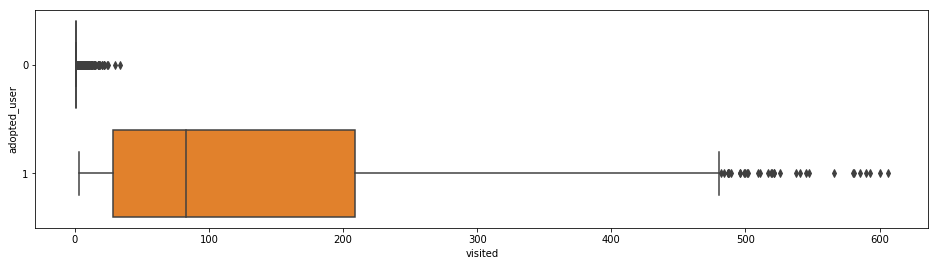

In [12]:
# plot the distribution of visits between adopted and non-adopted users
plt.figure(figsize=(16,4))
sns.boxplot(x='visited', y='adopted_user', data=users_df, orient='h')

### Identify which factors predict future user adoption.

creation_source
GUEST_INVITE          0.205290
ORG_INVITE            0.154015
PERSONAL_PROJECTS     0.191099
SIGNUP                0.144889
SIGNUP_GOOGLE_AUTH    0.148736
Name: adopted_user, dtype: float64


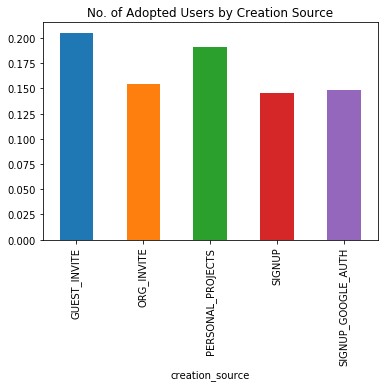

In [13]:
print(users_df.groupby('creation_source')['adopted_user'].sum() / users_df.groupby('creation_source')['adopted_user'].count())

(users_df.groupby('creation_source')['adopted_user'].sum() / users_df.groupby('creation_source')['adopted_user'].count()).plot(kind='bar', 
                                                               title='No. of Adopted Users by Creation Source')

Regardless of account creation type, all users had less than a 21% adoption rate. However, those that were invited as guests of an organization or invited to join another member's personal project appear to be slightly more likely to adopt the platform. This may indicate that users are more likely to adopt the platform if their is a social component to their participation. Further testing would be needed to confirm this assumption.

opted_in_to_mailing_list  adopted_user
0                         0               5531
                          1               1066
1                         0               1848
                          1                378
Name: adopted_user, dtype: int64


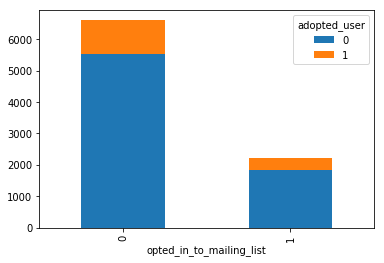

In [14]:
mail_list = users_df.groupby(['opted_in_to_mailing_list','adopted_user'])['adopted_user'].count()
print(mail_list)
mail_list.unstack().plot(kind='bar', stacked=True)

In [15]:
mail_list_unstack = mail_list.unstack()

# compute the percent of adopted users based on mailing list status
mail_list_unstack['pct'] = mail_list_unstack.iloc[1] / mail_list_unstack.sum(axis=1)
mail_list_unstack

adopted_user,0,1,pct
opted_in_to_mailing_list,,,
0,5531,1066,0.280127
1,1848,378,0.169811


Interestingly, users appear to be more likely to adopt the platform if they *did not* opt in to the mailing list.

In [16]:
# compute number of unique organizations
len(users_df.org_id.unique())

417

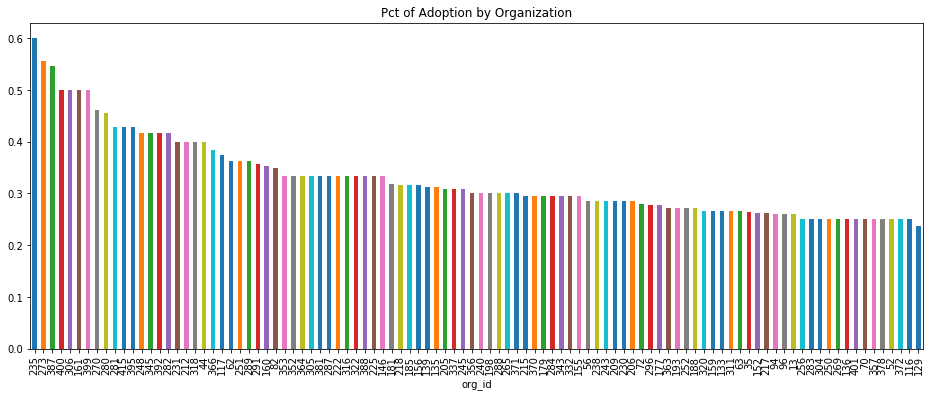

In [17]:
# compute the percent of adopted users by organization
org_adoption_pct = (users_df.groupby('org_id')['adopted_user'].sum() / users_df.groupby('org_id')['adopted_user'].count()).sort_values(ascending=False)

# the the 100 orgs with the highest adoption rate
org_adoption_pct[:100].plot(kind='bar', title='Pct of Adoption by Organization',figsize=(16,6))

We can see that there are only 3 organizations with an adoption rate above 50% and about 50 organizations with adoption above 33%. Out of 417 organizations, this leaves a small percentage of organizations that are converting users to adoption.

Next, we will compute the feature importances using a Gradient Boosting model to get a sense of what the model deems are important factors in predicting adoption.

In [18]:
# convert creation source categories to numerical codes
users_df['creation_source'] = pd.Categorical(users_df.creation_source).codes

In [19]:
# define features for gradient boosting model
features = users_df[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id','visited']].copy()

# convert missing data
features.invited_by_user_id.fillna(-1, inplace=True)

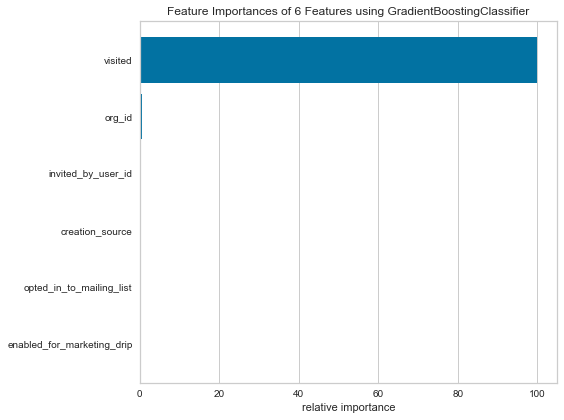

In [20]:
# plot feature importances using gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier
from yellowbrick.features.importances import FeatureImportances

X = features
y = users_df.adopted_user

# Create a new matplotlib figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(random_state=42), ax=ax)
viz.fit(X, y)
viz.poof()

In [21]:
# see how well the baseline GB model performs
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)  

0.978021978021978

## Conclusion
Based on the data provided, we can conclude that the most important factor in predicting whether a user will adopt the platform is the number of visits. Descriptive statistics point to this insight when we see that the mean number of logins for an unadopted user is 2 (with a max of 34) and the mean for an adopted user is 136 (with a max of 606). The gradient boosting algorithm seems to gain all of its information from the number of visits while creating a model with 97.8% accuracy. While a users number of visits gives us good predictive power, a more important questions might be why are certain users visiting more than others and how can we increase the number of visits from those users who are currently unlikely to adopt the platform. 

Some information can be gained in the descriptive statistcs produced above. For example, we saw that users are more likely to adopt who were invited to the platform through an organizational guest pass or a private project pass. It is advised to look more into this social aspect of the platform and see what the users and organizations who are inviting adopted users are doing differently. We also saw that users that signed up for the newsletter were less likely to adopt the service. Is the newsletter not driving traffic back to the website? Is it actively driving users away? These are questions that require more in-depth analysis. In addition, the gradient boosting feature importance indicates that the organization to which the user belongs (org_id) plays an important role in predicting adoption. The bar plot above shows that only 3 organizations have more than 50% of their users convert to adoption (and only about 50 of the 417 organizations convert more than 33%). It might be worth examining the difference between organizations that convert users to adopted versus those that don't.